In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sn
from math import sqrt
from pandas_datareader import data as dt

In [87]:
import datetime

In [211]:
precos = pd.DataFrame()

start = datetime.datetime(2020, 10, 13)
end = datetime.datetime(2021, 5, 1)

stocks = ["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"]

for i in stocks:
    precos[i] = dt.get_data_yahoo(i, start = start)['Close']
    
precos.dropna(inplace=True)

rets = precos.pct_change()

df = precos

In [212]:
precos.tail()

,ABEV3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,...,SULA11.SA,SUZB3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-23,17.360001,37.000000,13.65,29.980000,19.570000,22.780001,19.500000,8.50,27.969999,62.910000,...,29.320000,57.480000,39.709999,36.950001,15.09,16.750000,96.199997,43.860001,35.750000,26.590000
2021-08-24,17.590000,39.700001,13.90,30.600000,20.150000,23.379999,19.959999,8.47,28.660000,64.489998,...,30.260000,59.049999,39.939999,37.520000,15.47,17.940001,99.709999,43.540001,35.660000,27.900000
2021-08-25,17.580000,39.740002,13.99,30.500000,20.090000,23.420000,20.190001,8.52,28.760000,64.150002,...,30.000000,62.259998,39.610001,39.080002,15.44,17.940001,99.500000,43.380001,36.380001,27.969999
2021-08-26,17.110001,38.799999,13.66,30.070000,19.690001,22.969999,19.620001,8.28,28.030001,63.290001,...,29.280001,61.689999,38.139999,38.950001,14.63,17.320000,98.230003,43.139999,36.770000,27.940001
2021-08-27,17.059999,39.340000,13.81,30.440001,19.930000,23.240000,19.790001,8.32,28.959999,64.419998,...,29.620001,62.020000,38.220001,39.459999,14.71,18.490000,100.680000,43.500000,36.740002,27.559999


32

In [213]:
returns = df.pct_change()
covMatrix = returns.cov()
mean_returns = returns.mean()
sigma = returns.cov()
risk_free_rate = (1 + 0.0575)**(1/252)-1

In [214]:
noofport = 100000
weight = np.zeros((noofport,len(precos.columns)))
expectedreturn = np.zeros((noofport))
expectedvol = np.zeros((noofport))
sharpeRatio = np.zeros((noofport))

for k in range(noofport):
    w = np.array(np.random.random(len(precos.columns)))
    w = w/np.sum(w)
    weight[k,:] = w
    expectedreturn[k] = np.sum(mean_returns * w)
    expectedvol[k] = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    sharpeRatio[k] = expectedreturn[k]/expectedvol[k]

In [215]:
index = np.where(sharperatio == sharperatio.max())

In [216]:
sharpeRatio

array([0.07922278, 0.0827407 , 0.09056008, ..., 0.07358312, 0.09249465,
       0.07244946])

In [217]:
import matplotlib.pyplot as plt

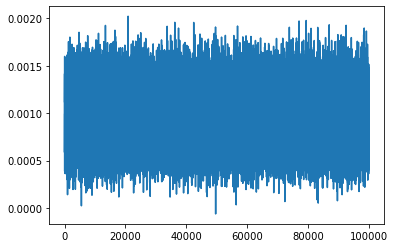

In [198]:
plt.plot(expectedreturn)

In [218]:
maxindex = np.where(sharpeRatio == sharpeRatio.max())
maxindex

(array([77573], dtype=int64),)

In [219]:
weight[maxindex,:]

array([[[0.01055413, 0.01872629, 0.00353611, 0.00326421, 0.01766051,
         0.00500579, 0.00507027, 0.00965086, 0.01797622, 0.00313537,
         0.02158518, 0.02474146, 0.03031887, 0.01279786, 0.01499519,
         0.01223009, 0.02967004, 0.01596529, 0.00355112, 0.02388296,
         0.01243345, 0.00336032, 0.01246592, 0.02080338, 0.01496639,
         0.01227831, 0.01656369, 0.01956909, 0.00550794, 0.02742471,
         0.0122565 , 0.01920058, 0.03062002, 0.01848274, 0.00535298,
         0.00929897, 0.01759752, 0.00147143, 0.02168943, 0.00885768,
         0.00775752, 0.01650608, 0.0289767 , 0.00017136, 0.01406782,
         0.01386177, 0.00271648, 0.01764171, 0.00291353, 0.00177094,
         0.01159687, 0.01290515, 0.00383544, 0.01115688, 0.01460075,
         0.00066229, 0.0160234 , 0.00149692, 0.02781594, 0.0307123 ,
         0.01253253, 0.02957287, 0.00827148, 0.00389704, 0.00348123,
         0.00449918, 0.02919461, 0.00968907, 0.00637019, 0.02663844,
         0.00046064, 0.00100131, 0

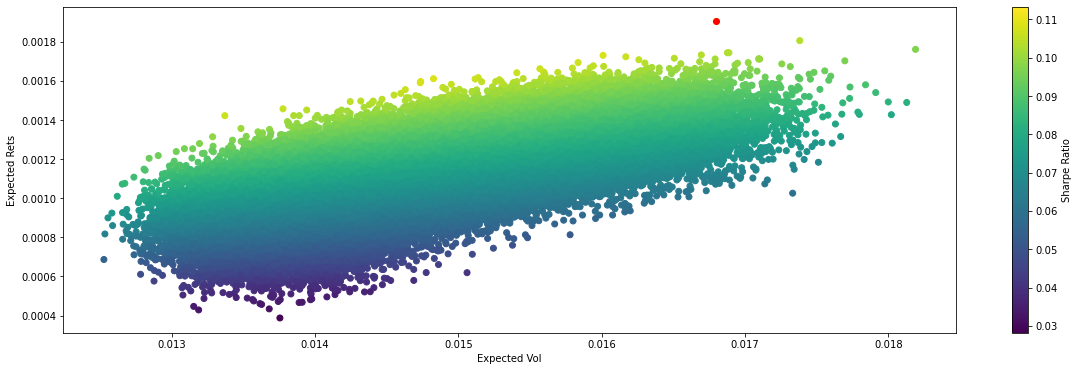

In [220]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.show()

In [143]:
import scipy

In [221]:
from scipy.optimize import minimize

def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    SR = R/V
    return -1*SR

def checksumtoone(w):
    return np.sum(w)-1
w0 = np.full((len(precos.columns)), 1/len(precos.columns)) #chute pesos (tudo igual)

#Limitando não poder ficar short (pesos entre 0 e 1)
a = [(0,1)]
for i in range (2,(len(precos.columns))+1):
    a.append((0,1))
a = tuple(a) 

bounds = (a)
constraints = ({'type':'eq','fun':checksumtoone})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
w_opt

     fun: -0.27380861422775343
     jac: array([ 9.24932919e-02,  1.23545300e-01,  2.14222118e-01,  1.65642925e-01,
        1.17749929e-01,  9.59734470e-02,  1.94282405e-01,  2.53931455e-01,
        2.47216579e-01,  7.38426745e-02,  2.25735642e-02,  5.37666641e-02,
        8.91089439e-06,  1.78325456e-01,  1.52932882e-01,  2.16120232e-01,
        5.09721190e-02,  3.29629309e-01,  9.66270901e-02,  1.16549015e-01,
        1.55090138e-01,  7.45226815e-02, -2.04220414e-05,  1.44296654e-01,
        2.80228365e-01,  2.07871754e-01,  1.22935481e-01,  7.23922402e-02,
        8.37619044e-02, -4.72739339e-06,  7.58965574e-02,  3.77549380e-02,
        7.77868181e-02,  6.84633739e-02,  3.14549308e-01,  1.43424068e-01,
        1.10251270e-01, -5.34288585e-04,  1.06711071e-01,  2.52729986e-01,
        2.71690302e-02,  2.67259777e-04,  1.04877416e-01,  1.68825895e-01,
        2.63127837e-01,  7.75247738e-02,  6.27623312e-02,  4.00196761e-04,
        2.58442923e-01,  8.08390416e-02,  6.14909351e-01,  

In [222]:
w_opt.x

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50184683e-16,
       1.84901973e-16, 6.73037186e-17, 2.13701039e-16, 7.65635831e-17,
       0.00000000e+00, 0.00000000e+00, 2.51405587e-18, 0.00000000e+00,
       2.02070590e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.75174173e-16, 0.00000000e+00, 1.74786109e-17, 1.33345308e-16,
       0.00000000e+00, 0.00000000e+00, 3.91669676e-02, 0.00000000e+00,
       5.16633308e-16, 7.68271644e-17, 1.58115286e-16, 0.00000000e+00,
       0.00000000e+00, 1.73747675e-01, 7.80305690e-17, 4.76678982e-18,
       0.00000000e+00, 0.00000000e+00, 4.92911877e-17, 0.00000000e+00,
       7.35811007e-17, 1.72969209e-02, 0.00000000e+00, 2.52357881e-16,
       1.52546829e-16, 5.38935732e-02, 7.71362125e-17, 0.00000000e+00,
       3.55549617e-16, 0.00000000e+00, 0.00000000e+00, 7.29833024e-02,
       0.00000000e+00, 4.49696415e-17, 2.04522044e-16, 5.09034288e-17,
       0.00000000e+00, 0.00000000e+00, 1.08792376e-01, 1.80208196e-16,
      

In [225]:
returns = np.linspace(0,0.002,50)
volatility_opt = []

def minimizevol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T,np.dot(sigma,w)))
    return V
def getreturn(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    return R
for R in returns:
    constraints = ({'type':'eq','fun':checksumtoone},
                  {"type":'eq','fun': lambda w: getreturn(w) - R})
    opt = minimize(minimizevol,w0,method = 'SLSQP',bounds = bounds, constraints = constraints)
    volatility_opt.append(opt['fun'])

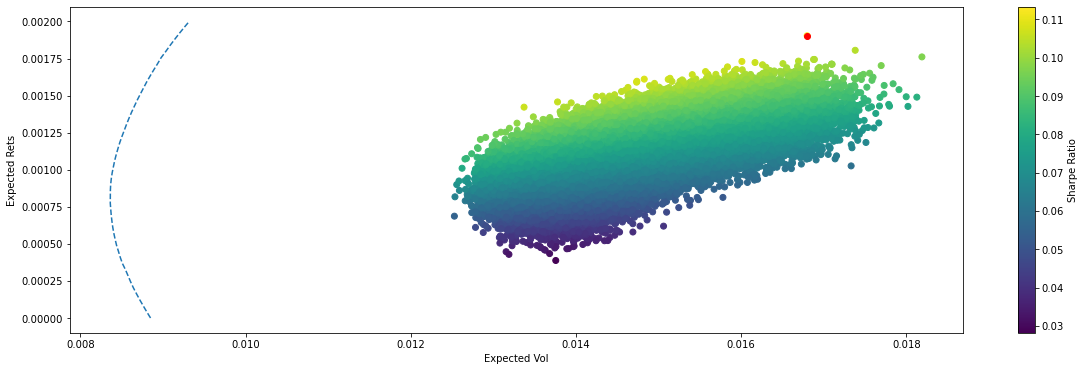

In [226]:
plt.figure(figsize=(20,6))
plt.scatter(expectedvol,expectedreturn,c=sharpeRatio)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Expected Vol')
plt.ylabel('Expected Rets')
plt.scatter(expectedvol[maxindex],expectedreturn[maxindex], c = 'red')
plt.plot(volatility_opt,returns,'--')
plt.show()

In [229]:
df = pd.DataFrame({'Ativos':["ABEV3.SA" , "AZUL4.SA" , "B3SA3.SA" , "BBAS3.SA" , "BBDC3.SA",  "BBDC4.SA" , "BBSE3.SA" , "BEEF3.SA", 
"BPAC11.SA", "BRAP4.SA" , "BRDT3.SA" , "BRFS3.SA" , "BRKM5.SA" , "BRML3.SA" , "CCRO3.SA" , "CIEL3.SA" ,
"CMIG4.SA"  ,"COGN3.SA" , "CPFE3.SA" , "CPLE6.SA" , "CRFB3.SA" , "CSAN3.SA" , "CSNA3.SA" , "CVCB3.SA" , "CYRE3.SA" ,
"ECOR3.SA"  ,"EGIE3.SA" , "ELET3.SA" , "ELET6.SA", "EMBR3.SA" , "ENBR3.SA" , "ENEV3.SA" , "ENGI11.SA", "EQTL3.SA" ,
"EZTC3.SA"  ,"FLRY3.SA" , "GGBR4.SA" , "GNDI3.SA" , "GOAU4.SA" , "GOLL4.SA" , "HAPV3.SA" , "HGTX3.SA" , "HYPE3.SA" ,
"IGTA3.SA"  ,"IRBR3.SA" , "ITSA4.SA" , "ITUB4.SA" , "JBSS3.SA" , "JHSF3.SA" , "KLBN11.SA", "LAME4.SA" , "LCAM3.SA" ,
"LREN3.SA"  ,"MGLU3.SA" , "MRFG3.SA" , "MRVE3.SA" , "MULT3.SA" , "NTCO3.SA" , "PCAR3.SA" , "PETR3.SA" , "PETR4.SA" ,
"PRIO3.SA"  ,"QUAL3.SA" , "RADL3.SA" , "RAIL3.SA" , "RENT3.SA" , "SANB11.SA", "SBSP3.SA" , "SULA11.SA", "SUZB3.SA" ,
"TAEE11.SA" , "TOTS3.SA" , "UGPA3.SA" , "USIM5.SA" , "VALE3.SA" , "VIVT3.SA" ,  "WEGE3.SA" ,"YDUQ3.SA"], 'Peso otimo':w_opt.x})

In [1]:
df.sort_values(by = 'Peso otimo', ascending = False)

NameError: name 'df' is not defined